# Making USDA Crop Data Maps with <i>Python</i>!
(inspired by Zachary Stansell's tweet: https://twitter.com/ZacharyStansell/status/1354612264679198722)

Note that this Notebook is designed to be executed as a ArcGIS Online Notebook and will require modification if used locally.

#### References:
* [USDA NASS Census of Agriculture Intro](https://www.nass.usda.gov/Publications/AgCensus/2017/Full_Report/Volume_1,_Chapter_1_US/usintro.pdf)
* [USDA NASS QuickStats API](https://quickstats.nass.usda.gov/api)
* [ArcGIS API for Python reference](https://developers.arcgis.com/python/api-reference/arcgis.mapping.toc.html?highlight=esriclassifynaturalbreaks#renderers)
* [Notebooks in ArcGIS Online](https://doc.arcgis.com/en/arcgis-online/get-started/get-started-with-notebooks.htm)

#### Setup and import libraries

In [2]:
import copy
import requests
# import arcpy # use the Advanced runtime and import arcpy if you want the feature layer to publish using a gdb instead of shp
import pandas as pd
from arcgis.gis import GIS
gis = GIS("home")

In [6]:
def get_key(key_name):
    df = pd.read_csv('accts.csv')
    key = df['KEY'][df['KEYNAME'] == key_name][0]
    return key

In [7]:
def get_crops():
    df = pd.read_csv('CropsList.csv')
    croplist = df['Commodity'].tolist()
    return croplist

#### Set parameters for the data query and maps

In [8]:
# Set API key
api_key = get_key("NASS API KEY")

In [9]:
# Get crop values
crops = get_crops()
# View crops
for i,crop in enumerate(crops):
    print(f'{i:3}. {crop}')

  0. ALMONDS
  1. APPLES
  2. APRICOTS
  3. AQUATIC PLANTS
  4. ARONIA BERRIES
  5. ARTICHOKES
  6. ASPARAGUS
  7. AVOCADOS
  8. BANANAS
  9. BARLEY
 10. BEANS
 11. BEDDING PLANT TOTALS
 12. BEETS
 13. BERRIES, OTHER
 14. BERRY TOTALS
 15. BLACKBERRIES
 16. BLUEBERRIES
 17. BOYSENBERRIES
 18. BROCCOLI
 19. BRUSSELS SPROUTS
 20. BUCKWHEAT
 21. BULBS & CORMS & RHIZOMES & TUBERS
 22. CABBAGE
 23. CAMELINA
 24. CANOLA
 25. CARROTS
 26. CAULIFLOWER
 27. CELERY
 28. CHERIMOYAS
 29. CHERRIES
 30. CHESTNUTS
 31. CHICKPEAS
 32. CHICORY
 33. CITRUS TOTALS
 34. CITRUS, OTHER
 35. COFFEE
 36. CORN
 37. COTTON
 38. CRANBERRIES
 39. CROP TOTALS
 40. CROPS, OTHER
 41. CUCUMBERS
 42. CURRANTS
 43. CUT CHRISTMAS TREES
 44. CUT CHRISTMAS TREES & SHORT TERM WOODY CROPS
 45. CUT FLOWERS & CUT CULTIVATED GREENS
 46. DAIKON
 47. DATES
 48. DILL
 49. EGGPLANT
 50. ELDERBERRIES
 51. EMMER & SPELT
 52. ESCAROLE & ENDIVE
 53. FIELD CROPS, OTHER
 54. FIGS
 55. FLAXSEED
 56. FLORICULTURE TOTALS
 57. FLORICULTURE,

In [10]:
# Set crop for query
cropnum = 117 # 36 is CORN for example
crops[cropnum] # this is the crop you'll be mapping

'PEANUTS'

In [11]:
# Query params
params = {
    'commodity_desc': crops[cropnum],
    'statisticcat_desc': 'AREA HARVESTED', # for field crops
    #'statisticcat_desc': 'AREA BEARING', # for tree crops
    'unit_desc':'ACRES',
    'domain_desc':'TOTAL',
    'domaincat_desc': 'NOT SPECIFIED',
    'agg_level_desc': 'COUNTY',
    'freq_desc': 'ANNUAL',
    'year': {'start':2012,'end':2021}
#     'state_alpha': 'MO'
}

#### Define query functions

In [12]:
def nass_query(baseurl,params):
    for p in params:
        if p != 'year':
            baseurl += f'&{p}={params[p]}'
        else:
            years = range(params[p]['start'],params[p]['end']+1)
            baseurl += ''.join([f'&year={y}' for y in years])
    queryurl = baseurl.replace(' ','%20')
    resp = requests.get(queryurl)
    try:
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        return "Error: " + str(e)
    return resp

def nass_params(api_key,sector_desc):
    paramsurl = f'http://quickstats.nass.usda.gov/api/get_param_values/?key={api_key}&param={sector_desc}'
    resp = nass_query(paramsurl,params={})
    params = resp.json()[sector_desc]
    return params

def nass_counts(api_key,params):
    counturl = f'http://quickstats.nass.usda.gov/api/get_counts/?key={api_key}'
    resp = nass_query(counturl,params)
    count = resp.json()['count']
    return count

def nass_data(api_key,params):
    dataurl = f'http://quickstats.nass.usda.gov/api/api_GET/?key={api_key}'
    resp = nass_query(dataurl,params)
    d = resp.json()['data']
    data = pd.DataFrame(d)
    return data

#### Query the USDA NASS API

In [13]:
# First check how many records the query will return
record_count = nass_counts(api_key,params)
record_count

2153

In [22]:
# Then submit your query
if record_count < 49999:
    d = nass_data(api_key,params)
else:
    # query by each year separately and then concat
    years = range(params['year']['start'],params['year']['end']+1)
    results = []
    for year in years:
        new_params = copy.deepcopy(params)
        new_params['year']['start'] = year
        new_params['year']['end'] = year
        ct = nass_counts(api_key,new_params)
        if ct > 0:
            res = nass_data(api_key,new_params)
        results.append(res)
    d = pd.concat(results,ignore_index=True)
print(f"{params['commodity_desc']}, {params['statisticcat_desc']} ({params['unit_desc']}), {params['year']['start']}-{params['year']['end']}: {d.shape[0]} results downloaded")

PEANUTS, AREA HARVESTED (ACRES), 2012-2021: 2153 results downloaded


In [23]:
# remove commas in Value
d['Value'] = d['Value'].str.replace(',','')

# filter out withheld data (see first link in References)
# may want to modify how this is handled since withheld data != 0
d = d[~d['Value'].isin(['                 (D)','                 (Z)'])].copy()

# change Value to numeric
d.Value = pd.to_numeric(d.Value)

In [27]:
d

,short_desc,CV (%),source_desc,state_alpha,region_desc,class_desc,year,prodn_practice_desc,state_name,county_ansi,...,county_name,reference_period_desc,freq_desc,begin_code,util_practice_desc,load_time,end_code,zip_5,unit_desc,Value
0,PEANUTS - ACRES HARVESTED,20.7,CENSUS,AL,,ALL CLASSES,2017,ALL PRODUCTION PRACTICES,ALABAMA,059,...,FRANKLIN,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2018-02-01 00:00:00,00,,ACRES,700
1,PEANUTS - ACRES HARVESTED,20.7,CENSUS,AL,,ALL CLASSES,2017,ALL PRODUCTION PRACTICES,ALABAMA,079,...,LAWRENCE,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2018-02-01 00:00:00,00,,ACRES,4390
3,PEANUTS - ACRES HARVESTED,20.7,CENSUS,AL,,ALL CLASSES,2017,ALL PRODUCTION PRACTICES,ALABAMA,103,...,MORGAN,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2018-02-01 00:00:00,00,,ACRES,34
4,PEANUTS - ACRES HARVESTED,20.7,CENSUS,AL,,ALL CLASSES,2017,ALL PRODUCTION PRACTICES,ALABAMA,009,...,BLOUNT,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2018-02-01 00:00:00,00,,ACRES,357
5,PEANUTS - ACRES HARVESTED,39.8,CENSUS,AL,,ALL CLASSES,2012,ALL PRODUCTION PRACTICES,ALABAMA,009,...,BLOUNT,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2012-12-31 00:00:00,00,,ACRES,459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,PEANUTS - ACRES HARVESTED,,SURVEY,VA,,ALL CLASSES,2016,ALL PRODUCTION PRACTICES,VIRGINIA,,...,OTHER (COMBINED) COUNTIES,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2018-05-10 15:00:31,00,,ACRES,7100
2149,PEANUTS - ACRES HARVESTED,,SURVEY,VA,,ALL CLASSES,2015,ALL PRODUCTION PRACTICES,VIRGINIA,,...,OTHER (COMBINED) COUNTIES,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2017-05-11 15:00:20,00,,ACRES,1900
2150,PEANUTS - ACRES HARVESTED,,SURVEY,VA,,ALL CLASSES,2014,ALL PRODUCTION PRACTICES,VIRGINIA,,...,OTHER (COMBINED) COUNTIES,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2016-05-05 15:04:45,00,,ACRES,1900
2151,PEANUTS - ACRES HARVESTED,,SURVEY,VA,,ALL CLASSES,2013,ALL PRODUCTION PRACTICES,VIRGINIA,,...,OTHER (COMBINED) COUNTIES,YEAR,ANNUAL,00,ALL UTILIZATION PRACTICES,2015-05-07 15:00:14,00,,ACRES,2300


In [24]:
d.columns

Index(['short_desc', 'CV (%)', 'source_desc', 'state_alpha', 'region_desc',
       'class_desc', 'year', 'prodn_practice_desc', 'state_name',
       'county_ansi', 'statisticcat_desc', 'state_ansi', 'country_code',
       'group_desc', 'commodity_desc', 'asd_code', 'location_desc',
       'congr_district_code', 'agg_level_desc', 'domain_desc', 'country_name',
       'county_code', 'sector_desc', 'watershed_desc', 'watershed_code',
       'asd_desc', 'state_fips_code', 'week_ending', 'domaincat_desc',
       'county_name', 'reference_period_desc', 'freq_desc', 'begin_code',
       'util_practice_desc', 'load_time', 'end_code', 'zip_5', 'unit_desc',
       'Value'],
      dtype='object')

In [25]:
d.state_alpha.unique()

array(['AL', 'AR', 'CA', 'FL', 'GA', 'HI', 'LA', 'MS', 'MO', 'NM', 'NC',
       'OK', 'SC', 'TX', 'VA'], dtype=object)

In [26]:
d[['state_alpha','Value']].groupby(by="state_alpha").sum()

,Value
state_alpha,
AL,1811981
AR,52400
CA,80
FL,1391096
GA,7530041
HI,3
LA,2690
MO,1293
MS,299302


#### Clean and process data

In [15]:
# remove commas in Value
d['Value'] = d['Value'].str.replace(',','')

# filter out irrelevant Values
d = d[~d['Value'].isin(['                 (D)','                 (Z)'])].copy()

# change Value to numeric
d.Value = pd.to_numeric(d.Value)

# add id field (State + County FIPS)
d['id'] = d['state_fips_code']+d['county_code']

# group by this new id
sumdf = d.groupby(['id']).mean()
sumdf = sumdf.reset_index()[['id', 'Value']]

# round the values
sumdf['Value'] = sumdf['Value'].round().astype(int)

# view final table
sumdf.head()

,id,Value
0,01001,444
1,01003,22240
2,01005,2928
3,01009,408
4,01011,1118


#### Join crop data with US counties

<Item title:"USA Counties (Generalized)" type:Feature Layer Collection owner:esri_dm>
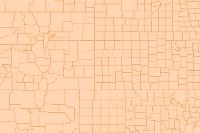

In [16]:
# Item Added From Toolbar
# Title: USA Counties (Generalized) | Type: Feature Service | Owner: esri_dm
uscounties = gis.content.get("7566e0221e5646f99ea249a197116605")
uscounties

In [17]:
# access data from this item in a spatially-enabled data frame
sdf = pd.DataFrame.spatial.from_layer(uscounties.layers[0])
sdf.head()

,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_5_9,AGE_65_74,AGE_75_84,...,SHAPE,SQMI,STATE_FIPS,STATE_NAME,Shape_Area,Shape_Leng,Shape__Area,Shape__Length,VACANT,WHITE
0,88,104,249,514,597,771,435,105,108,40,...,"{""rings"": [[[-17677357.9077045, 7719547.390490...",7036.89,02,Alaska,2.235582,24.266646,4.886230e+10,3.299975e+06,194,660
1,504,604,528,786,910,1237,1056,465,662,539,...,"{""rings"": [[[-10779852.8004753, 5981411.784141...",862.51,38,North Dakota,0.266362,2.150449,4.881826e+09,2.837745e+05,386,7809
2,731,674,486,1099,1147,1840,1604,620,1064,763,...,"{""rings"": [[[-10898454.0980662, 6139525.267360...",1294.14,38,North Dakota,0.411900,3.379906,7.683728e+09,4.117952e+05,752,10391
3,226,249,334,972,1137,1232,786,227,157,31,...,"{""rings"": [[[-18550860.9655057, 7080282.503091...",3597.77,02,Alaska,0.889389,18.731621,1.831491e+10,2.455085e+06,717,2004
4,3622,4245,6458,9486,6880,7883,6374,3907,3891,2754,...,"{""rings"": [[[-11239339.6270714, 6082615.148233...",2055.85,38,North Dakota,0.640877,4.408571,1.192105e+10,5.964787e+05,1715,55718


In [18]:
# merge in our crop data
cropsdf = pd.merge(sdf, sumdf, how='left', left_on='FIPS', right_on='id')

# calculate total acres from sq mi
cropsdf['ACRES'] = cropsdf['SQMI']*640

# calculate crop acres per 1000 county acres
cropsdf['ValueNorm'] = (cropsdf['Value'] / cropsdf['ACRES']) * 1000

cropsdf.head()

,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_5_9,AGE_65_74,AGE_75_84,...,Shape_Area,Shape_Leng,Shape__Area,Shape__Length,VACANT,WHITE,id,Value,ACRES,ValueNorm
0,88,104,249,514,597,771,435,105,108,40,...,2.235582,24.266646,4.886230e+10,3.299975e+06,194,660,NaN,NaN,4503609.6,NaN
1,504,604,528,786,910,1237,1056,465,662,539,...,0.266362,2.150449,4.881826e+09,2.837745e+05,386,7809,NaN,NaN,552006.4,NaN
2,731,674,486,1099,1147,1840,1604,620,1064,763,...,0.411900,3.379906,7.683728e+09,4.117952e+05,752,10391,NaN,NaN,828249.6,NaN
3,226,249,334,972,1137,1232,786,227,157,31,...,0.889389,18.731621,1.831491e+10,2.455085e+06,717,2004,NaN,NaN,2302572.8,NaN
4,3622,4245,6458,9486,6880,7883,6374,3907,3891,2754,...,0.640877,4.408571,1.192105e+10,5.964787e+05,1715,55718,NaN,NaN,1315744.0,NaN


#### Publish crop layer and display as a map

In [19]:
# Publish as layer in ArcGIS Online
croplyr = cropsdf.spatial.to_featurelayer(f'{crops[cropnum]}', folder='USDA Crops')
croplyr
#croplyr = gis.content.get('627286d4b1c14ad28bdef63416239619')

<Item title:"PEANUTS" type:Feature Layer Collection owner:mbass@esri.com_prof_services>

In [20]:
# Display our map
m1 = gis.map('USA',zoomlevel=4)
m1.add_layer({"type":"FeatureLayer", 
               "url":croplyr.layers[0].url,
               #"definition_expression" : "STATE_NAME='Missouri'",
               "renderer":"ClassedColorRenderer",
               #"field_name":"Value",
               "field_name":"ValueNorm",
               "opacity":0.7
              })
m1.basemap = 'dark-gray'
#m1.legend = True
print(f'{crops[cropnum]}')
m1

PEANUTS


MapView(layout=Layout(height='400px', width='100%'))

#### Alternative: Map from Spatially-Enabled Dataframe

In [ ]:
m2 = gis.map('USA',zoomlevel=4)
m2.basemap = 'dark-gray'
m2

In [ ]:
cropsdf.spatial.plot(map_widget=m2,
                     renderer_type='c',  # for class breaks renderer
                     method='esriClassifyQuantile',  # classification algorithm
                     class_count=7,  # choose the number of classes
                     col='ValueNorm',  # numeric column to classify
                     cmap='Blues',  # color map to pick colors from for each class
                     outline_style = 'n', # set outline to null
                     alpha = 0.1
               )

For details on parameters, see [ArcGIS API for Python reference](https://developers.arcgis.com/python/api-reference/arcgis.mapping.toc.html?highlight=esriclassifynaturalbreaks#renderers)
##### method options:
 * esriClassifyDefinedInterval
 * esriClassifyEqualInterval
 * esriClassifyGeometricalInterval
 * esriClassifyNaturalBreaks
 * esriClassifyQuantile
 * esriClassifyStandardDeviation
 * esriClassifyManual

##### cmap options: 
optional string or list. This is the color scheme a user can provide if the exact color is not needed, or a user can provide a list with the color defined as: [red, green blue, alpha]. The values red, green, blue are from 0-255 and alpha is a float value from 0 - 1. The default value is ‘jet’ color scheme.

In [ ]:
from arcgis.mapping import display_colormaps
display_colormaps()